In [1]:
import os
import sys
notebook_dir = os.getcwd()
project_dir = os.path.dirname(notebook_dir)
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
from srcs.engdataset import ENGDataset, Nerve
import utils.preprocessing as pre
import utils.classify as classify
import utils.plot as uplot

from constants import *
# from utils.encoding import *    
# from utils.preprocess_analog import *
from srcs.gest_sp_encoder import GestSpEncoder
from brian2 import *
import numpy as np
import pandas as pd
import pickle as pkl
import os
import seaborn as sns
from collections import namedtuple, Counter
import matplotlib.gridspec as gridspec

%load_ext autoreload
%autoreload 2


plt.rcParams.update({"figure.dpi": 150})
plt.rcParams['axes.axisbelow'] = True
logging.getLogger().setLevel(logging.INFO)
matplotlib.rcParams.update({'font.size': 6})

plt.rcParams.update({
            "figure.dpi": 150, 'font.size': 10,
            'figure.figsize': (5,3), 'axes.axisbelow': True,
            'axes.edgecolor': COLOR_DICT['clouds'], 'axes.linewidth': 0.4
        })
logging.getLogger().setLevel(logging.INFO)

## Load post-processed data for encoding

In [2]:
# load raw ENG for the following parameters
day = 16                   # day of recording
session = '01'             # session of recording

preproc_plots = False      # whether to plot figures during preprocessing
filter_signal = False      # whether to filter all channels or reload a saved file with filtered data
save_figs = True

Gest_namedtup = namedtuple('gesture', ['id', 'phase'])


# encoding parameters
encode_signal = True
save_encoding = True


In [3]:
eng_dataset = ENGDataset(day= day, session=session, load_raw_data = True, save_figs=save_figs)
pipeline = {'bp_order': 3, 'bp_cutoff_freq': np.array([300, 2000]), 'notch_bandwidth': 0.5, 'notch_reject': 50}
eng_dataset.filt_pipeline = pipeline

INFO:root:Loading data from /Users/farahbaracat/Library/CloudStorage/OneDrive-UniversitätZürichUZH/ENG upper dataset/Data_TIME_Marina/day16/AM_prese_1601_raw_ENG.mat
INFO:root:Loading data from /Users/farahbaracat/Library/CloudStorage/OneDrive-UniversitätZürichUZH/ENG upper dataset/Data_TIME_Marina/day16/AM_prese_1601_raw_ENG_ok.mat
INFO:root:Creating dictionary of reps count per task: {0: 10, 1: 10, 2: 10, 3: 7, 4: 10}
INFO:root:Time column of post_data(7157879,) 
Rec column of post_data(56, 7157879)


In [6]:
# load filtered ENG data
filt_filename = f"day{eng_dataset.day}{eng_dataset.session}_eng_filt_{eng_dataset.filt_pipeline['bp_cutoff_freq'][0]}_{eng_dataset.filt_pipeline['bp_cutoff_freq'][1]}.pkl"
filt_df = pd.read_pickle(os.path.join(FILTERED_DIR, filt_filename))
eng_dataset.filt_df = filt_df

# delete raw
eng_dataset._detete_raw_data()

AttributeError: 'ENGDataset' object has no attribute 'raw_data'

In [7]:

# create directory if it doesn't exist
if not os.path.exists(ENCODED_DIR):
    os.makedirs(ENCODED_DIR)


# create directory for figures if it doesn't exist
FIG_ENC_DIR = os.path.join(FIG_DIR, 'encoding')

if not os.path.exists(FIG_ENC_DIR):
    os.makedirs(FIG_ENC_DIR)

# Encode with LIF neurons in Brian2

what to encode to spikes:
- the power?
- Square of signal?
- Fitlered signal + downsampled?

In [8]:
def encode_to_spikes(signal, bin_width, tau_mem=20*ms, vth=0.5, sub_n_chs= 10, duration=None, scale=True,vmin=None, vmax=None, chs_to_exclude=[1,2,43]):
    """
    signal: pandas df of shape (time, n_channels). All channels are encoded simultaneously.
    """

    n_ch = signal.shape[1]
    logging.info(f"Encoding {n_ch} channels")

    # # exclude bad channels before normalization
    # signal = remove_bad_chs(signal) 
    
    if vmin is None and vmax is None:
        vmin = signal.drop(chs_to_exclude,axis=1).min().min()
        vmax = signal.drop(chs_to_exclude,axis=1).max().max()

    start_scope()

    LIF_eqs = '''
    dv_mem/dt = (Iin-v_mem)/tau_mem  : 1
    Iin = Ifeat_scaled(t,i): 1
    '''
    ch_pow = signal.to_numpy()

    if scale:
        # Scale channels to range(0,1)
        ch_pow_rescaled = (ch_pow - vmin)/ (vmax- vmin)    
        Ifeat_scaled = TimedArray(ch_pow_rescaled, dt=bin_width*second)
    else:
        Ifeat_scaled = TimedArray(ch_pow, dt=bin_width*second)

    # setup network
    neuron_in = NeuronGroup(n_ch, LIF_eqs, threshold='v_mem > vth',reset='v_mem = 0', name='input_neuron')
    
    spike_mon = SpikeMonitor(neuron_in)
    state_mon = StateMonitor(neuron_in, variables=['v_mem'], record=True)
    monitors = [spike_mon, state_mon]

    # Create network
    net = Network(neuron_in, monitors)
    print(f"Encoding {n_ch}")

    # Simulate
    if duration is None:
        sim_duration = len(ch_pow)*bin_width  #+ bin_width
        logging.info(f"Simulating for {sim_duration} seconds")
    else:
        sim_duration = duration
        
    net.run(sim_duration*second)

    return spike_mon, state_mon

In [9]:
def plot_heatmap(df, title, ax, cbar_label=None, vmin=None, vmax=None, cbar=False, ylabel= 'Channels', xlabel='Reps', yticks_label=None,  
                 xticks_label=None, ticks_step=5, xticks_step=4):
    
    hmap = sns.heatmap(df,ax=ax, cbar_kws={'label': cbar_label}, cmap='rocket_r', vmin=vmin, vmax=vmax, cbar=cbar)
    # ax.figure.axes[-1].yaxis.label.set_size(20)

    if cbar:
        cbar = hmap.collections[0].colorbar
        cbar.set_label(cbar_label, labelpad=2, fontsize=8)

    ax.set_title(title, fontsize=10)
    if yticks_label is not None:
        ax.set_yticks(np.arange(0,len(df.index),ticks_step), minor=False)
        hmap.set_yticklabels(yticks_label[::ticks_step], rotation=0, fontsize=6)
  
    if xticks_step is not None:
        ax.set_xticks(np.arange(0,len(df.columns),xticks_step), minor=False, rotation=0)
        if xticks_label is not None:
            hmap.set_xticklabels(xticks_label[::xticks_step], ha='center',rotation=0)

        # hmap.set_xticklabels(np.arange(0,53,ticks_step), rotation=0, fontsize=6)

    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)
 

## Power of the signal

In [10]:
# get bad channels
# bad_channels, bad_channels_std = pre.detect_bad_channels(eng_dataset, std_threshold=5)
# print(f"Bad channels:{bad_channels}\nBad channels std:{np.round(bad_channels_std,3)}")
# bad_channels = [1,2,43]

In [11]:
# n_chs = signal_df.shape[1]
# sp_times, sp_ids  = copy_spmon(encoded_pow)

# # Visualize
# fig = plt.figure(figsize=(3,4))
# gs = gridspec.GridSpec(nrows=2, ncols=1)

# # figure styling
# show_nxticks = 2

# ax = fig.add_subplot(gs[0])
# ax.plot(sp_times, sp_ids, '|', color = COLOR_DICT['midnight_blue'], markersize=3,
#         alpha = 0.7)
# ax.set_ylim([0, n_chs])
# ax.set_xlim([0,FLX_DUR])
# ax.set_yticks([])
# ax.set_xticks(np.arange(0,FLX_DUR,FLX_DUR/show_nxticks))


# ax.set_title(f" Task id {task_id}| Rep {rep_id} | {phase} | {wind_size} sec", fontsize=8)
# sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
# plt.ylabel("Encoded Channels", labelpad=YLAB_PAD)
# plt.tight_layout()


# ax = fig.add_subplot(gs[1])
# # subset_bins_flx_stat = signal.drop([1,2,43],axis=1).iloc[:,:n_chs]
# plot_heatmap(signal_df.iloc[:,::-1].T, '', ax, cbar=False, ylabel=None, xlabel='')
# n_bins =  flex_feat_df.shape[0]
# bins_aranged = flex_feat_df[TIME_VAR]
# every_nth = 10
# ax.set_xticks(np.arange(0,n_bins, every_nth), bins_aranged[::every_nth])
# # plt.ylabel("Channels")
# # plt.xlabel("Time [sec]")
# # def plot_heatmap(df, title, ax, cbar_label=None, vmin=None, vmax=None, cbar=False, ylabel= 'Channels', xlabel='Reps', yticks_label=None,  xticks_label=None, ticks_step=5, xticks_step=4):


### Encode Signal Squared

Probably it makes more sense to encode the square of the signal, such that the first layer of LIFs would integrate and hence compute the power.

**Considerations**:
- Downsampling the signal to avoid saturation in spikes.
- Adjust the time constants per channel?

In [12]:
# wind_size = 0.99 # in sec
# ol = 0
# feature = 'mav'
# phase = 'open'      # phase of the gesture: open or close

# flex_feat_df, ext_feat_df, rest_feat_df = pre.extract_feature_for_task_rep(eng_dataset,task_id,rep_id,
#                                                                             feature, wind_size, overlap_perc=ol)
# flex_feat_df.shape

In [13]:
# import copy
# # Test encoding for a single rep and task
# task_id = 0
# phase = 'open'      # phase of the gesture: open or close

# # Encoding parameters
# tau_mem = 50 *ms
# vth= 0.02

# # feature parameters
# wind_size = 0.1 # in sec
# ol = 0
# feature = 'mav'
# aux_cols = [TIME_VAR, FEAT_WIN_COL, REP_ID_COL]

# fig = plt.figure(figsize=(10, 6))
# gs = gridspec.GridSpec(nrows=2, ncols=5)

# for rep_id in range(eng_dataset.task_rep_count[task_id]): # eng_dataset.task_rep_count[task_id]
#     flex_feat_df, ext_feat_df, rest_feat_df = pre.extract_feature_for_task_rep(eng_dataset,task_id,rep_id,
#                                                                             feature, wind_size, overlap_perc=ol)

#     if phase == 'close':  # flexion/close phase
#         signal_df = flex_feat_df.drop(aux_cols, axis=1)

#     elif phase == 'open':  # extension/ open phase
#         signal_df = ext_feat_df.drop(aux_cols, axis=1)

#     # exclude bad channels
#     signal_df = signal_df.drop(bad_channels, axis=1)

#     # encode
#     encoded_pow, vmem = encode_to_spikes(signal_df, bin_width=wind_size,tau_mem=tau_mem,vth=vth)

#     n_chs = signal_df.shape[1]
#     sp_times, sp_ids  = copy_spmon(encoded_pow)

#     # Visualize
#     ax = fig.add_subplot(gs[rep_id])
#     ax.plot(sp_times, sp_ids, '|', color = COLOR_DICT['midnight_blue'], markersize=2, alpha = 0.7)
#     ax.set_ylim([0, n_chs])
#     ax.set_xlim([0,FLX_DUR])
#     ax.set_yticks([])
#     ax.set_xticks(np.arange(0,FLX_DUR,FLX_DUR/show_nxticks))
#     sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
#     ax.set_ylabel("Encoded Channels", labelpad=YLAB_PAD)

# fig.tight_layout()

# # save figure
# fig.savefig(os.path.join(FIG_ENC_DIR, 
#             f"all_reps_task{task_id}_channels_{feature}_{phase}.png"),
#             dpi=300, bbox_inches='tight')


In [14]:
# pkl_file = f'{ENCODED_DIR}/engfullwave_to_spikes_tau_{float(tau_mem)})_vth_{vth}_{tuple_to_list}.pkl'
# pkl_file

In [15]:
# rep_df,rep_st, rep_et = get_single_rep_for_task(eng_dataset, rep_id, task_id)

# rep_df_flx, rep_df_ext = split_rep_to_flex_ext(rep_df, rep_st, rep_et, eng_dataset)
# rep_df_flx

# Encode all

In [17]:
import copy

def copy_spmon(encoded_sp):
    sp_times = copy.deepcopy(np.array(encoded_sp.t))
    sp_ids = copy.deepcopy(np.array(encoded_sp.i))
    return sp_times, sp_ids




def organize_tasks_spikes(gest_sp_dict):
    """Converts spike monitors to arrays of spike times and ids.
    gest_sp_dict: a dict (key = rep_id) of dict(key=phase) and value = spike monitor"""

    spikes = {}
    for rep_id in gest_sp_dict.keys():
        spikes[rep_id] = {}
        for phase in gest_sp_dict[rep_id].keys():
            sp_times, sp_ids = copy_spmon(gest_sp_dict[rep_id][phase])
            spikes[rep_id][phase] = (sp_times, sp_ids)
    return spikes



In [18]:
"""
New encoding parameters
"""
# Neuron parameters
tau_mem = 30 * ms  # default 20ms
vth = 0.02    # default 0.05

# Feature parameters
# wind_size = 0.02 # in sec
# ol = 0
# feature = 'mav'

# Encode all reps from the gestures of interest
LABEL_COL = 'label'

Gest = namedtuple('gesture', ['id', 'phase'])
sel_gest = [Gest(0,'ext'),Gest(1,'flx'), Gest(3,'flx'),Gest(4,'flx')] 
bad_channels = []
tuple_to_list = [f'{gest_tuple.id}_{gest_tuple.phase}'for gest_tuple in sel_gest]
pkl_file = f'{ENCODED_DIR}/engfullwave_to_spikes_tau_{float(tau_mem)}_vth_{vth}_{tuple_to_list}_nofeature_remove_{bad_channels}.pkl'

# todo: fill in the tmp_data_df first then do the encoding. 
if encode_signal:
    eng_to_sp = []


    for col, gest_tuple in enumerate(sel_gest):
        tmp = {}
        
        # reps_count = n_reps[gest_tuple.id]
        task_id = gest_tuple.id
        for row, rep_id in enumerate(range(eng_dataset.task_rep_count[task_id])):
            rep_df,rep_st, rep_et = pre.get_single_rep_for_task(eng_dataset, rep_id, task_id)
            assert rep_df.shape[0] > 0, f"Empty repetition {rep_id} for task {task_id}"
            rep_df_flx, rep_df_ext = pre.split_rep_to_flex_ext(rep_df, rep_st, rep_et, eng_dataset)


            tmp[rep_id]= {}

            if gest_tuple.phase == 'flx':
                # signal_df = flex_feat_df.drop(aux_cols, axis=1)
                signal_df = rep_df_flx.drop([TIME_VAR], axis=1)
            elif gest_tuple.phase == 'ext':
                # signal_df = ext_feat_df.drop(aux_cols, axis=1)
                signal_df = rep_df_ext.drop([TIME_VAR], axis=1)
            print(signal_df.shape)
            print(f"Encoding rep {rep_id} for task {gest_tuple.id} ({TASK_ORDER[gest_tuple.id]})  phase:{gest_tuple.phase}")
        

            # encoded_sp,encoded_vmem = encode_to_spikes(signal_df, 
            #                                            bin_width=wind_size, 
            #                                            tau_mem=tau_mem, 
            #                                            vth=vth, 
                                                    #    scale=True)
            encoded_sp,encoded_vmem = encode_to_spikes(np.abs(signal_df), 
                                                       bin_width=1/eng_dataset.fs, 
                                                       tau_mem=tau_mem, 
                                                       vth=vth, 
                                                       scale=True,
                                                       chs_to_exclude=bad_channels)
            print(f"{gest_tuple}   duration:{np.array(encoded_vmem.t).max()} sec")

            tmp[rep_id][gest_tuple.phase]= encoded_sp
            print("------------------\n")
        
        eng_to_sp.append(tmp)

    # Organize the data: convert the SpikeMonitors into GestSpEncoder objects
    # eng_to_sp: list(gesture) of dict(rep) of dict(phase) of SpikeMonitors

    gest_encoder = []  
    for gest_i in range(len(eng_to_sp)):
        spikes = organize_tasks_spikes(eng_to_sp[gest_i])
        print(spikes)
        gest_encoder.append(GestSpEncoder(spikes, gest_label=sel_gest[gest_i].id, label_to_gest= TASK_ORDER))
    
    # Save to pickle
    if save_encoding:
        with open(pkl_file, 'wb') as f:
            pkl.dump(gest_encoder, f)

else:  # load encoded data
    with open(pkl_file, 'rb') as f:
        gest_encoder = pkl.load(f)

INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


(30000, 56)
Encoding rep 0 for task 0 (Tripod)  phase:ext
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=0, phase='ext')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 1 for task 0 (Tripod)  phase:ext
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=0, phase='ext')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 2 for task 0 (Tripod)  phase:ext
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=0, phase='ext')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 3 for task 0 (Tripod)  phase:ext
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=0, phase='ext')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 4 for task 0 (Tripod)  phase:ext
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=0, phase='ext')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 5 for task 0 (Tripod)  phase:ext
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=0, phase='ext')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 6 for task 0 (Tripod)  phase:ext
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=0, phase='ext')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 7 for task 0 (Tripod)  phase:ext
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=0, phase='ext')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 8 for task 0 (Tripod)  phase:ext
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=0, phase='ext')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 9 for task 0 (Tripod)  phase:ext
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=0, phase='ext')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 0 for task 1 (ThOpp.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=1, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 1 for task 1 (ThOpp.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=1, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 2 for task 1 (ThOpp.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=1, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 3 for task 1 (ThOpp.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=1, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 4 for task 1 (ThOpp.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=1, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 5 for task 1 (ThOpp.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=1, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 6 for task 1 (ThOpp.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=1, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 7 for task 1 (ThOpp.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=1, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 8 for task 1 (ThOpp.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=1, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 9 for task 1 (ThOpp.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=1, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 0 for task 3 (UlnarFing.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=3, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 1 for task 3 (UlnarFing.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=3, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 2 for task 3 (UlnarFing.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=3, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 3 for task 3 (UlnarFing.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=3, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 4 for task 3 (UlnarFing.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=3, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 5 for task 3 (UlnarFing.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=3, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 6 for task 3 (UlnarFing.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=3, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 0 for task 4 (FingAbd.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO       No numerical integration method specified for group 'input_neuron', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


gesture(id=4, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 1 for task 4 (FingAbd.)  phase:flx
Encoding 56


INFO:root:building '_cython_magic_3391fac6fcec8a18825a1f092489c379' extension
INFO:root:clang -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/snn_iemg/include -fPIC -O2 -isystem /opt/anaconda3/envs/snn_iemg/include -I/opt/anaconda3/envs/snn_iemg/include -I/opt/anaconda3/envs/snn_iemg/lib/python3.11/site-packages/numpy/core/include -I/opt/anaconda3/envs/snn_iemg/lib/python3.11/site-packages/brian2/synapses -I/opt/anaconda3/envs/snn_iemg/include/python3.11 -c /Users/farahbaracat/Library/Caches/cython/brian_extensions/_cython_magic_3391fac6fcec8a18825a1f092489c379.cpp -o /Users/farahbaracat/Library/Caches/cython/brian_extensions/Users/farahbaracat/Library/Caches/cython/brian_extensions/_cython_magic_3391fac6fcec8a18825a1f092489c379.o -w -O3 -ffast-math -fno-finite-math-only -march=native -std=c++11
INFO:root:clang++ -bundle -undefined dynamic_lookup -Wl,-rpath,/opt/anaconda3/envs/snn_iemg/lib -L/opt/anaconda3/envs/snn_iemg/lib -Wl,-rpath,/opt/anaconda3/envs/snn_iemg/lib 

gesture(id=4, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 2 for task 4 (FingAbd.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds


gesture(id=4, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 3 for task 4 (FingAbd.)  phase:flx
Encoding 56
gesture(id=4, phase='flx')   duration:0.9999 sec
------------------



INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds


(30000, 56)
Encoding rep 4 for task 4 (FingAbd.)  phase:flx
Encoding 56
gesture(id=4, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 5 for task 4 (FingAbd.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds


gesture(id=4, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 6 for task 4 (FingAbd.)  phase:flx
Encoding 56
gesture(id=4, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 7 for task 4 (FingAbd.)  phase:flx
Encoding 56


INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds
INFO:root:Encoding 56 channels
INFO:root:Simulating for 1.0 seconds


gesture(id=4, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 8 for task 4 (FingAbd.)  phase:flx
Encoding 56
gesture(id=4, phase='flx')   duration:0.9999 sec
------------------

(30000, 56)
Encoding rep 9 for task 4 (FingAbd.)  phase:flx
Encoding 56
gesture(id=4, phase='flx')   duration:0.9999 sec
------------------

{0: {'ext': (array([0.5185, 0.727 , 0.7287, 0.7297, 0.7591, 0.8166, 0.82  , 0.8388,
       0.8498, 0.8602, 0.9704]), array([ 5, 43, 43, 43,  5, 43, 43,  5, 43,  1, 43], dtype=int32))}, 1: {'ext': (array([0.0168, 0.0295, 0.0352, 0.0501, 0.0626, 0.0641, 0.0673, 0.0987,
       0.0988, 0.1099, 0.1208, 0.1257, 0.1393, 0.1602, 0.1633, 0.1719,
       0.1803, 0.1975, 0.1979, 0.2095, 0.2214, 0.2267, 0.2356, 0.2451,
       0.2478, 0.2523, 0.2628, 0.2649, 0.2803, 0.281 , 0.2816, 0.3011,
       0.3061, 0.3068, 0.317 , 0.3215, 0.3295, 0.3299, 0.3385, 0.346 ,
       0.3474, 0.3488, 0.3565, 0.3657, 0.3682, 0.3776, 0.3787, 0.3798,
       0.3868, 0.3931, 0.3

In [19]:
print(gest_encoder[1].gest_label, gest_encoder[2].gest_label)
rep_test = 0
print(Counter(gest_encoder[1].spikes[rep_test]['flx'][1]))
print(Counter(gest_encoder[2].spikes[rep_test]['flx'][1]))

1 3
Counter({43: 18, 5: 8, 7: 8, 29: 1, 2: 1})
Counter({5: 185, 7: 174, 2: 150, 17: 134, 29: 134, 22: 84, 28: 61, 37: 59, 32: 56, 46: 54, 45: 51, 48: 50, 19: 49, 14: 47, 18: 46, 47: 44, 16: 44, 15: 43, 24: 42, 31: 40, 23: 38, 34: 36, 25: 35, 44: 33, 53: 33, 30: 30, 20: 30, 52: 30, 27: 29, 38: 29, 33: 29, 26: 28, 35: 27, 43: 26, 51: 25, 21: 24, 42: 23, 1: 23, 4: 23, 39: 23, 40: 23, 41: 22, 0: 22, 3: 22, 36: 21, 54: 20, 50: 19, 8: 19, 12: 19, 13: 18, 10: 18, 9: 18, 55: 17, 6: 16, 11: 16, 49: 15})


In [20]:
# Assuming the required data and variables are defined elsewhere:
# gest_encoder, eng_dataset, sel_gest, COLOR_DICT, TASK_ORDER, N_CHANNELS, save_figs, FIG_DIR, DAY, SESSION, tau_mem, vth

def compute_spike_counts(gest_encoder, eng_dataset, sel_gest):
    sp_count_df = pd.DataFrame()
    row = 0

    for i in range(len(gest_encoder)):
        Enc = gest_encoder[i]
        for rep in range(eng_dataset.task_rep_count[sel_gest[i].id]):
            gest_sp_ids = Enc.get_sp_for_rep(rep, sel_gest[i].phase)[1]
            sp_count = Counter(gest_sp_ids)

            sp_count_df.loc[row, list(sp_count.keys())] = list(sp_count.values())
            sp_count_df.loc[row, 'rep'] = rep
            sp_count_df.loc[row, 'gest'] = sel_gest[i].id
            row += 1

    return sp_count_df

def plot_spike_counts(sp_count_df, gest_encoder, sel_gest, map_phase_name, COLOR_DICT, TASK_ORDER, N_CHANNELS, save_figs, FIG_DIR, DAY, SESSION, tau_mem, vth):
    n_cols = len(gest_encoder)
    gs = gridspec.GridSpec(10, n_cols)   # nrows are reps

    fig = plt.figure(figsize=(15, 10))
    bwidth = 0.8

    for i in range(len(gest_encoder)):

        for rep in range(eng_dataset.task_rep_count[sel_gest[i].id]):
            ax = fig.add_subplot(gs[rep, i])
            sp_count = sp_count_df[(sp_count_df['rep'] == rep) & (sp_count_df['gest'] == sel_gest[i].id)]
            sp_count = sp_count.drop(columns=['rep', 'gest']).iloc[0].dropna().to_dict()

            ax.bar(sp_count.keys(), sp_count.values(), width=bwidth, color=COLOR_DICT['midnight_blue'], alpha=0.85)
            plt.xticks(np.arange(0, N_CHANNELS, 5))

            if i == 0:
                plt.ylabel(f"Rep#{rep}")

            if rep == 0:
                plt.title(f"{TASK_ORDER[sel_gest[i].id]}  {map_phase_name[sel_gest[i].phase]}", fontsize=8)

            plt.xlim([0, N_CHANNELS])
            plt.tight_layout()
            plt.box(False)
        plt.xlabel("Channels", fontsize=8)

    # save fig
    if save_figs:
        filename = f"day{DAY}{SESSION}_fullrect_spike_count_taumem_{tau_mem}_vth_{vth}_exclude_bad_chs_pinch_{sel_gest[i].phase}.png"
        fig.savefig(os.path.join(FIG_DIR, filename), dpi=300)

    plt.show()



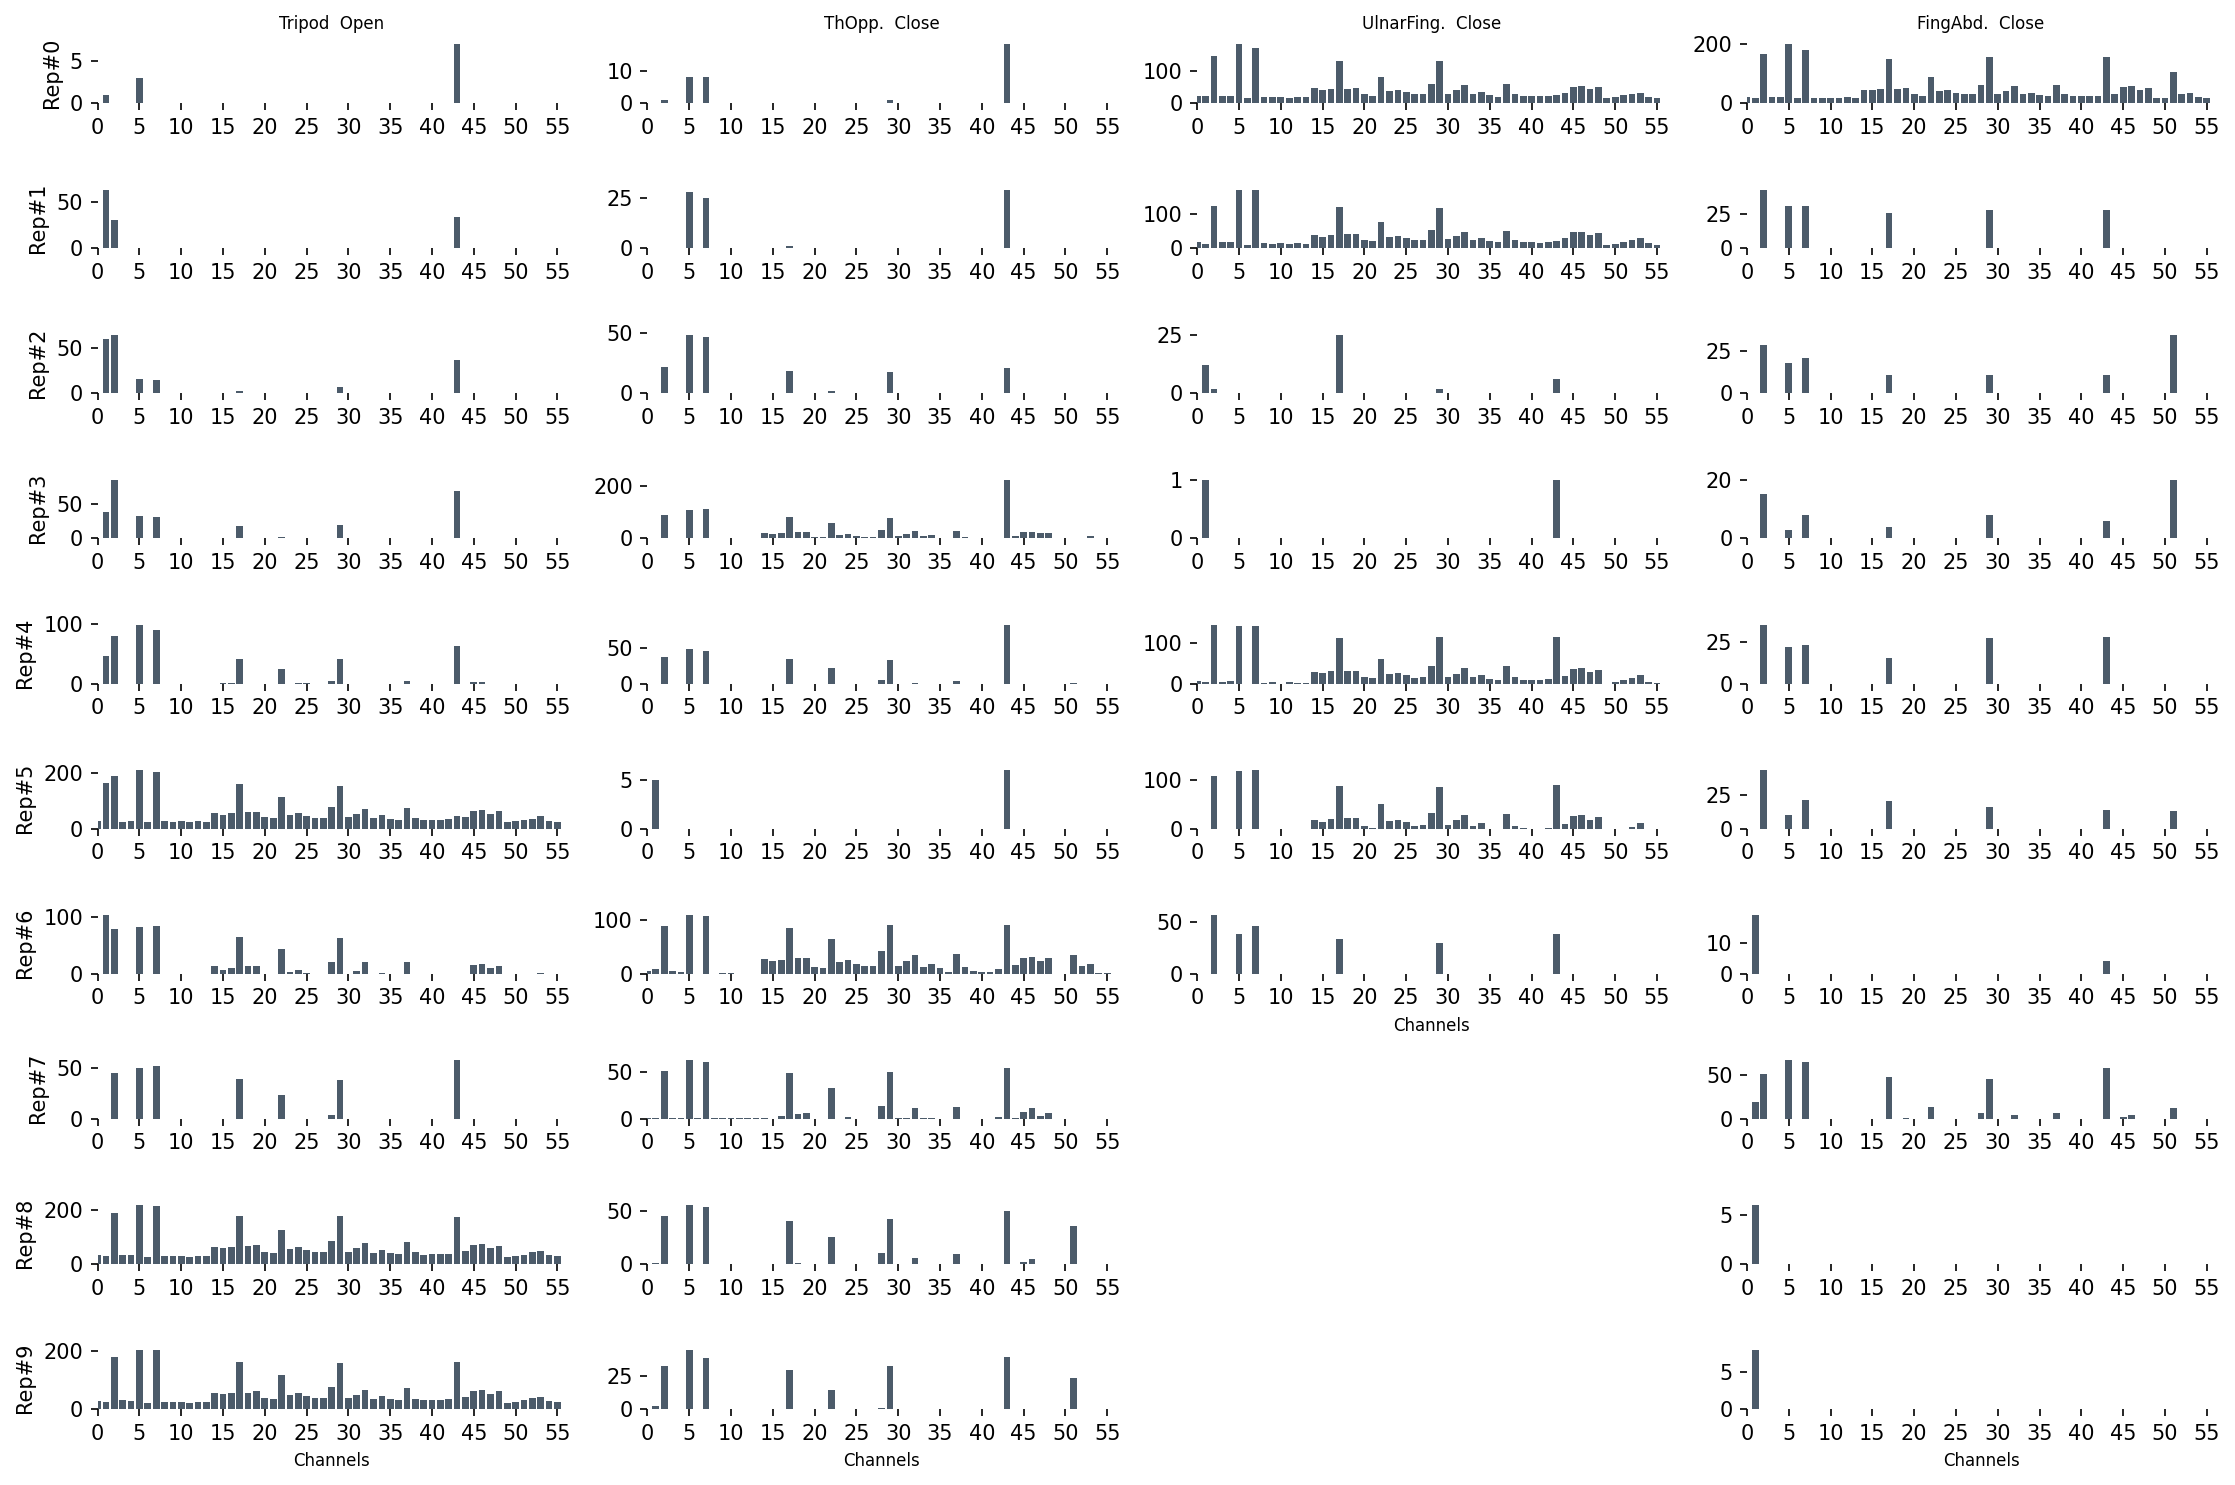

In [21]:
# Map phase names
map_phase_name = {'ext': 'Open', 'flx': 'Close'}

# Compute spike counts
sp_count_df = compute_spike_counts(gest_encoder, eng_dataset, sel_gest)

# Plot spike counts
plot_spike_counts(sp_count_df, gest_encoder, sel_gest, map_phase_name, COLOR_DICT, TASK_ORDER, N_CHANNELS, save_figs, FIG_DIR, DAY, SESSION, tau_mem, vth)


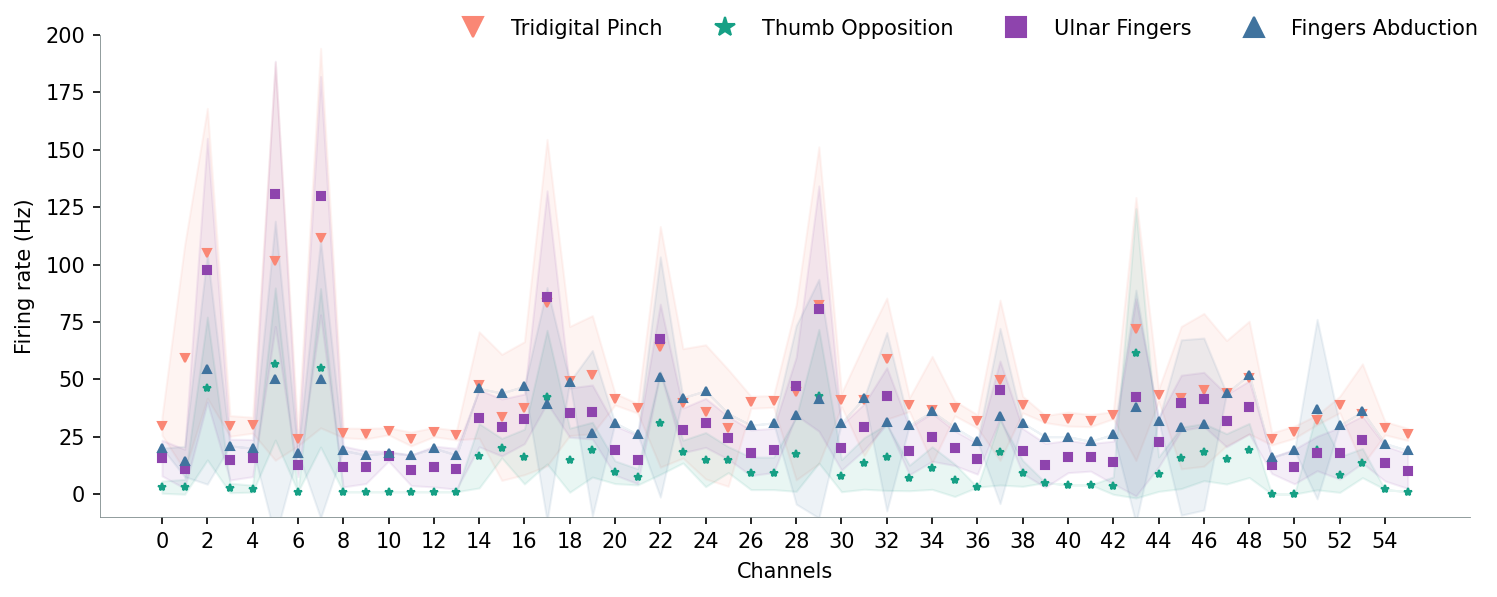

In [23]:
from constants import *
# Compute spike counts
sp_count_df = compute_spike_counts(gest_encoder, eng_dataset, sel_gest)
sp_count_df['gest'] = sp_count_df['gest'].map({0:'Tripod Open', 1:'ThOpp. Close', 3:'UlnarFing. Close', 4:'FingAbd.'})


# group the spike count per gesture averaging over reps
mean_sp_count = sp_count_df.groupby(['gest']).mean().drop('rep',axis=1)
std_sp_count = sp_count_df.groupby(['gest']).std().drop('rep',axis=1)

# sorting channels in ascending order
mean_sp_count = mean_sp_count.reindex(sorted(mean_sp_count.columns), axis=1)  
std_sp_count = std_sp_count.reindex(sorted(std_sp_count.columns), axis=1)   

# order gestures
mean_sp_transp = mean_sp_count.T
mean_sp_transp = mean_sp_transp[list(CLASS_TO_GEST.values())]

std_sp_transp = std_sp_count.T
std_sp_transp = std_sp_transp[list(CLASS_TO_GEST.values())]


# fill na with 0
mean_sp_transp.fillna(0, inplace=True)
std_sp_transp.fillna(0, inplace=True)

fig = plt.figure(figsize=(10,4))


ax = fig.add_subplot(111)
markers = ['v','*', 's', '^']
bwidth= 0.3

markers = ['v','*', 's', '^']
bwidth= 0.3

capsize= 2

for i, g in enumerate(list(CLASS_TO_GEST.values())):
    plt.plot(np.array(mean_sp_count.columns), mean_sp_transp[g],markers[i], color=GEST_COLORS[i], markersize=4, label=g)
    # add shaded area for std
    plt.fill_between(np.array(mean_sp_count.columns), mean_sp_transp[g]-std_sp_transp[g], 
                     mean_sp_transp[g]+std_sp_transp[g], alpha=0.09, color=GEST_COLORS[i])

# Add legend
handles = [plt.Line2D([], [], color=GEST_COLORS[i], 
                    marker=markers[i],
                        markersize=10, linestyle='None') for i in range(4)]

legend_label = ['Tridigital Pinch', 'Thumb Opposition', 'Ulnar Fingers', 'Fingers Abduction']
leg = fig.legend(handles=handles, labels=legend_label,
                 loc='upper right', 
                #  bbox_to_anchor=(0.5, 1.), 
                 ncols=4, frameon=False)


plt.xticks(mean_sp_count.columns.to_numpy()[::2], mean_sp_count.columns.to_numpy()[::2])
plt.xlabel("Channels", labelpad=XLAB_PAD)
plt.ylabel("Firing rate (Hz)", labelpad=YLAB_PAD)
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
# plt.xlim([-1, N_CHANNELS-3])
plt.ylim([-10,200])
fig.tight_layout()

# save figures
if save_figs:
    # filename = f"day{DAY}{SESSION}_scatter_avg_and_std_spike_freq_taumem_{tau_mem}_vth_{vth}_exclude_bad_chs_pinch_{sel_gest[0].phase}.png"
    filename= f'day{DAY}{SESSION}_scatter_plot_avg_and_std_spike_freq_taumem_{float(tau_mem)}_vth_{vth}.png'
    fig.savefig(os.path.join(FIG_DIR, filename), dpi=300, bbox_inches='tight')


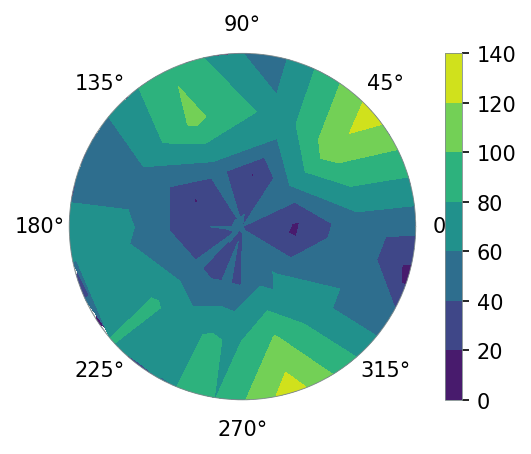

In [24]:
import matplotlib.cm as cm

#actual plotting
chs = mean_sp_count.columns  #sp_count_df.drop(['rep', 'gest'], axis=1).columns
ax = plt.subplot(111, polar=True)
ax.set_yticklabels([])

ctf = ax.contourf(chs, np.arange(4), mean_sp_count, cmap=cm.viridis)
plt.colorbar(ctf)
plt.show()

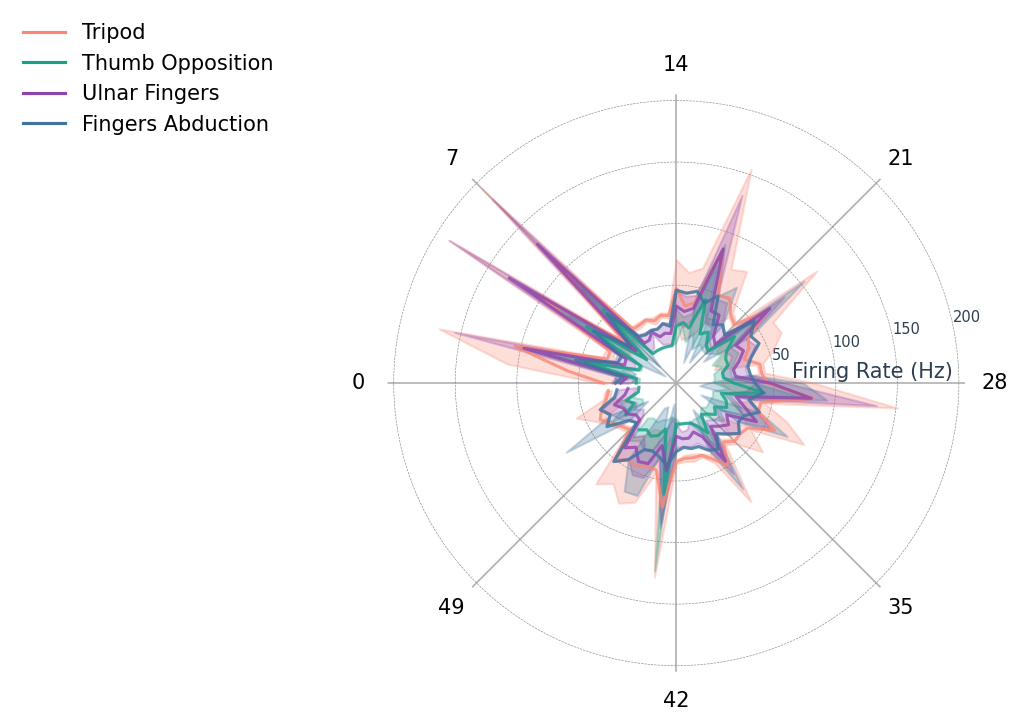

In [26]:
# MANPLOT: create a spider plot for the firing rates in mean_sp_count and std_sp_count
# Initialize variables
chs = mean_sp_count.columns

# Figure styling
mean_fr_alpha = 0.8
std_fr_alpha = 0.27
theta_start = 0
theta_end = 360
theta_step = 360/len(chs)

radial_fr_start = 50 # first displayed firing rate in Hz
radial_fr_end = 210
radial_fr_step = 5
radial_label_angle = 168

display_n_chs = 8  # number of angles to show on the plot. Here each angle is a channel.
display_n_rate = 3  # number of inner circles to show. Each circle marks firing rate.

radial_ticks = np.arange(radial_fr_start, radial_fr_end, radial_fr_step)  
thetagrids = np.arange(theta_start, theta_end, theta_step)
theta_display_step = int(len(chs)/display_n_chs) 
radial_display_step = int(len(radial_ticks)/ display_n_rate)

# Arange channels in radians
channels_in_radians = np.linspace(0, 2*np.pi, len(chs), endpoint=False)

# Transpose and reorder
mean_sp_transp = mean_sp_count.T
mean_sp_transp = mean_sp_transp[list(CLASS_TO_GEST.values())]


# Create the spider plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, polar=True)

# # Add shaded areas for each quarter
# colors_quarters = ['lightgray', 'lightblue', 'lightgreen', 'lightcoral']
# for i in range(4):
#     start_angle = i * (np.pi/2)
#     end_angle = (i + 1) * (np.pi/2)
#     ax.fill_betweenx(radial_ticks, start_angle, end_angle, color=colors_quarters[i], alpha=0.3)


# Plot each gesture's mean and std
for i, g in enumerate(list(CLASS_TO_GEST.values())):
    ax.plot(channels_in_radians, mean_sp_transp[g], label=g, color=GEST_COLORS[i], alpha=mean_fr_alpha)
    ax.fill_between(channels_in_radians, mean_sp_transp[g]-std_sp_transp[g], 
                     mean_sp_transp[g]+std_sp_transp[g], alpha=std_fr_alpha, 
                     color=GEST_COLORS[i])
    
# Set theta and radial axes parameters
ax.set_yticklabels([])
ax.set_theta_offset(np.pi)
ax.set_theta_direction(-1)
ax.set_thetagrids(thetagrids[::theta_display_step], chs[::theta_display_step])

ax.set_rticks(radial_ticks)
ax.set_rgrids(radial_ticks[::radial_display_step], labels=radial_ticks[::radial_display_step], 
              angle=radial_label_angle, fontsize=7, color=COLOR_DICT['midnight_blue'])
ax.spines['polar'].set_visible(False)

# set color of radial gridlines
ax.yaxis.grid(True, color=COLOR_DICT['clouds'], linestyle='dashed', linewidth=0.3)

# Set label for radial and theta axis
ax.text(0.7, 0.51, 'Firing Rate (Hz)', transform=ax.transAxes, rotation=0, 
        color=COLOR_DICT['midnight_blue'], fontsize=10)

# Add legend
handles = [plt.Line2D([], [], color=GEST_COLORS[i]) for i in range(len(CLASS_TO_GEST))]

legend_label = ['Tripod', 'Thumb Opposition', 'Ulnar Fingers', 'Fingers Abduction']
leg = fig.legend(handles=handles, labels=legend_label,
                 loc='upper right', bbox_to_anchor=(0, 1.),
                 ncols=1, frameon=False)

# save figure
if save_figs:
    filename = f"day{DAY}{SESSION}_spider_plot_avg_and_std_spike_freq_taumem_{float(tau_mem)}_vth_{vth}.png"
    fig.savefig(os.path.join(FIG_DIR, filename), dpi=300, bbox_inches='tight')


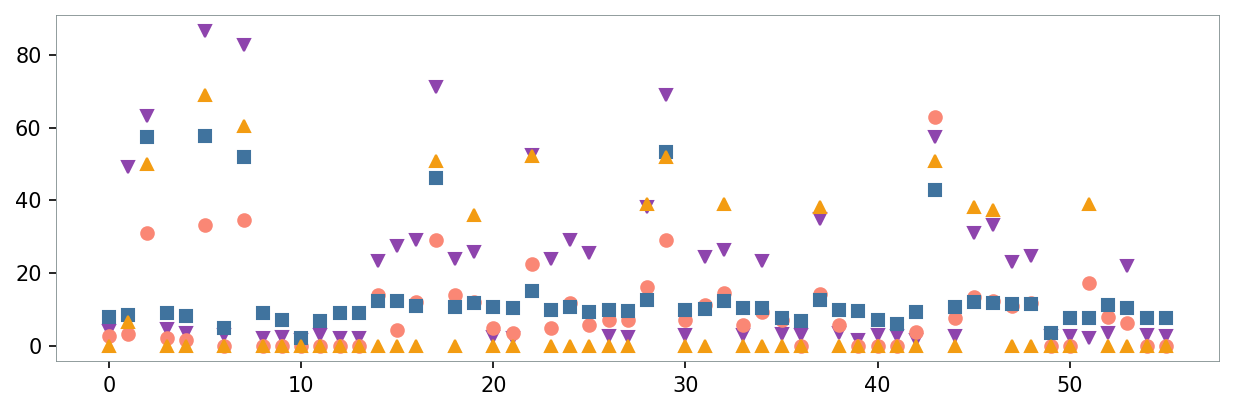

In [27]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)

c = [COLOR_DICT['wisteria'], COLOR_DICT['viz_orange'], COLOR_DICT['naval'], COLOR_DICT['orange']]
markers = ['v','o', 's', '^']
bwidth= 0.3


for i, g in enumerate(list(CLASS_TO_GEST.values())):
    plt.plot(np.array(std_sp_count.columns), std_sp_transp[g],markers[i], color=c[i], markersize=6, label=g)
plt.show()

### Mean Firing Rate Per Gesture

In [28]:
CLASS_TO_GEST.keys()

dict_keys([0, 1, 2, 3])

In [29]:
def modify_electrode_string(original_string):
    # Replace underscore with space
    modified_string = original_string.replace('_', ' ')

    # Replace 'elec' with 'electrode '
    final_string = modified_string.replace('elec', '')
    return final_string

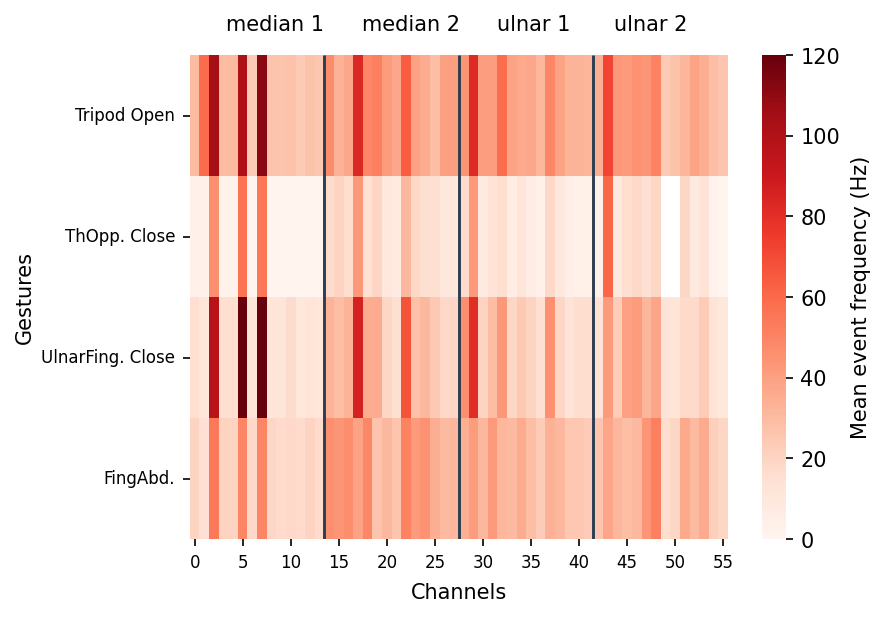

In [33]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

# uplot.plot_heatmap(mean_sp_transp, ax=ax, cbar=True, cbar_label='Mean event frequency (Hz)',yticks_label=mean_sp_transp.index,
#                    xticks_label=mean_sp_transp.columns, yticks_step=5, xticks_step=1,
#                   title="",xlabel='Gestures', vmin=0, vmax=170, cmap='Greys')  
mean_sp_count_ordered = mean_sp_count.T[list(CLASS_TO_GEST.values())].T
uplot.plot_heatmap(mean_sp_count_ordered, ax=ax, cbar=True, cbar_label='Mean event frequency (Hz)',
                   yticks_label=mean_sp_count_ordered.index,
                   xticks_label=mean_sp_count_ordered.columns, yticks_step=1, xticks_step=5,
                  title="",ylabel='Gestures', xlabel='Channels', vmin=0, vmax=120, cmap='Reds')  
for e, electrode in enumerate(eng_dataset.nerves_ch_group.keys()):
    if e > 0:
        ax.vlines(eng_dataset.nerves_ch_group[electrode][0], 0, 4, linestyle='solid', linewidth=1.4,
                  colors=COLOR_DICT['midnight_blue'])

    # add electrode annotation
    if e<2:
        fig.text(0.26+0.15*e, 0.99 , f'{modify_electrode_string(electrode.value)}')
    else:
        fig.text(0.3+0.13*e, 0.99 , f'{modify_electrode_string(electrode.value)}')

fig.tight_layout()
# save figures
if save_figs:
    filename = f"day{DAY}{SESSION}_avg_spike_freq_taumem_{float(tau_mem)}_vth_{vth}_pinch_{sel_gest[0].phase}.png"
    fig.savefig(os.path.join(FIG_DIR, filename), dpi=300, bbox_inches='tight')